### What the lady (Sandra?) asked
- benchmark: K-means
- innitialization: random vs k-means
- modalities: T1-w vs T1-w+FLAIR
- metrics: DSC, num iterations, comp.time

# Still to do:
 - Fix label matching between gt and predictions
 - Boxplots and tables:
    - One for iterations: four bxplts t1_km, t1_em, t1_t2_km, t1_t2_em
    - One for time: four bxplts t1_km, t1_em, t1_t2_km, t1_t2_em
    - One for dice: four bxplts t1_km, t1_em, t1_t2_km, t1_t2_em
 - Boxplots and tables:
    - One for iterations: four bxplts t1_em_kminit, t1_t2_em_kminit, t1_em_random, t1_t2_em_random
    - One for time: four bxplts t1_em_kminit, t1_t2_em_kminit, t1_em_random, t1_t2_em_random
    - One for dice: four bxplts t1_em_kminit, t1_t2_em_kminit, t1_em_random, t1_t2_em_random

In [1]:
import utils
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
from pathlib import Path
from sklearn.cluster import KMeans
from src import ExpectationMaximization

In [2]:
def brain_tissue_segmentation(t1, t2, brain_mask, mode):
    # T1+T2
    t1_vector = t1[brain_mask == 255].flatten()
    t2_vector = t2[brain_mask == 255].flatten()
    data = np.array([t1_vector, t2_vector]).T
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init='kmeans',
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=True, use_our_gauss_likelihood=False)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1_t2 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_t2_seg_res = predictions.reshape(t1.shape)
    # T1
    data = np.array(t1_vector)[:, np.newaxis]
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init='kmeans',
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=True, use_our_gauss_likelihood=False)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_seg_res = predictions.reshape(t1.shape)
    return t1_seg_res, t1_t2_seg_res, t_t1, t_t1_t2


def dice_score(gt, pred):
    classes = np.unique(gt[gt != 0])
    dice = np.zeros((len(classes)))
    for i in classes:
        bin_pred = np.where(pred == i, 1, 0)
        bin_gt = np.where(gt == i, 1, 0)
        dice[i-1] = np.sum(pred[bin_gt == 1]) * 2.0 / (np.sum(pred) + np.sum(gt))
    return dice.tolist()


def plots(t1_array, t2_array,  t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt, slice_n = 20):
    plt.figure(figsize=(20, 5))
    plt.subplot(171)
    plt.title('T1')
    plt.imshow(t1_array[slice_n, :, :], cmap='gray')
    plt.axis('off')
    plt.subplot(172)
    plt.title('T2')
    plt.imshow(t2_array[slice_n, :, :], cmap='gray')
    plt.axis('off')
    
    plt.subplot(173)
    plt.title('EM T1')
    plt.imshow(t1_seg_res_em[slice_n, :, :])
    plt.axis('off')
    plt.subplot(174)
    plt.title('KMeans T1')
    plt.imshow(t1_seg_res_km[slice_n, :, :])
    plt.axis('off')
    plt.subplot(175)
    plt.title('EM T1+T2')
    plt.imshow(t1_t2_seg_res_em[slice_n, :, :])
    plt.axis('off')
    plt.subplot(176)
    plt.title('KMeans T1+T2')
    plt.imshow(t1_t2_seg_res_km[slice_n, :, :])
    plt.axis('off')
    
    plt.subplot(177)
    plt.title('GT')
    plt.imshow(gt[slice_n, :, :])
    plt.axis('off')
    plt.show()

-------------------- Subject N°0 --------------------


  9%|▉         | 9/100 [00:01<00:15,  5.72it/s]


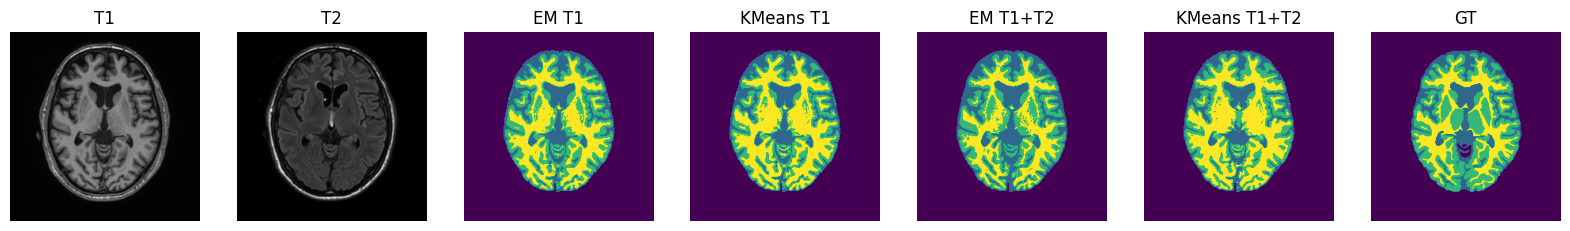

-------------------- Subject N°1 --------------------


  4%|▍         | 4/100 [00:00<00:18,  5.15it/s]


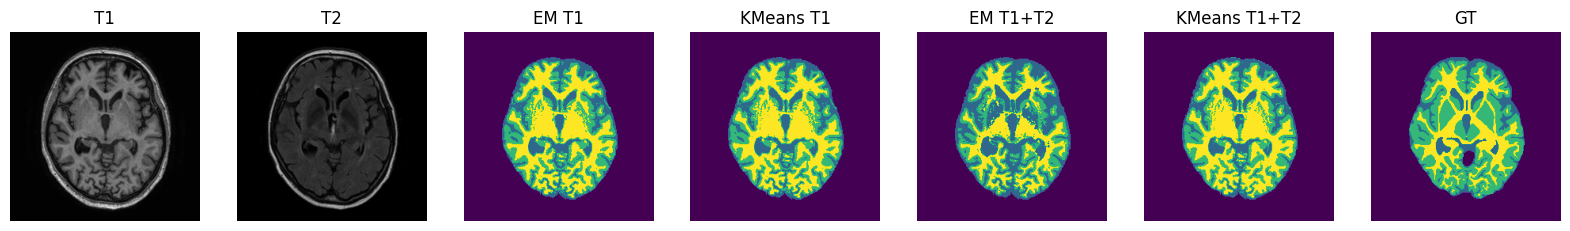

-------------------- Subject N°2 --------------------


 12%|█▏        | 12/100 [00:02<00:14,  5.89it/s]


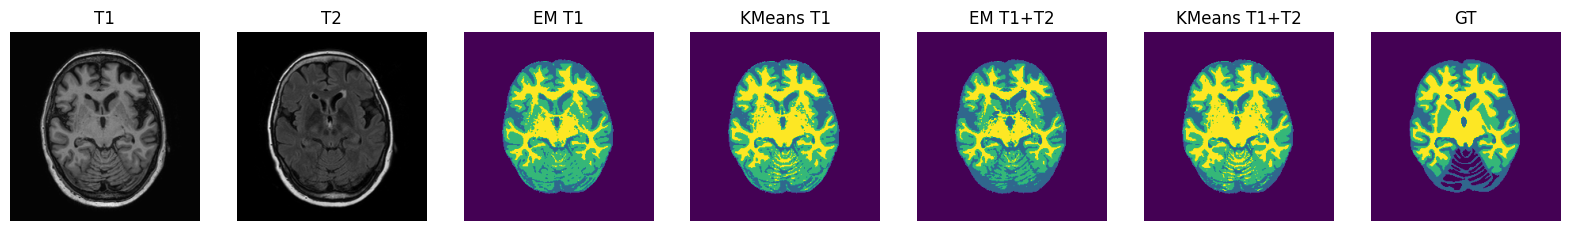

-------------------- Subject N°3 --------------------


 11%|█         | 11/100 [00:01<00:14,  6.35it/s]


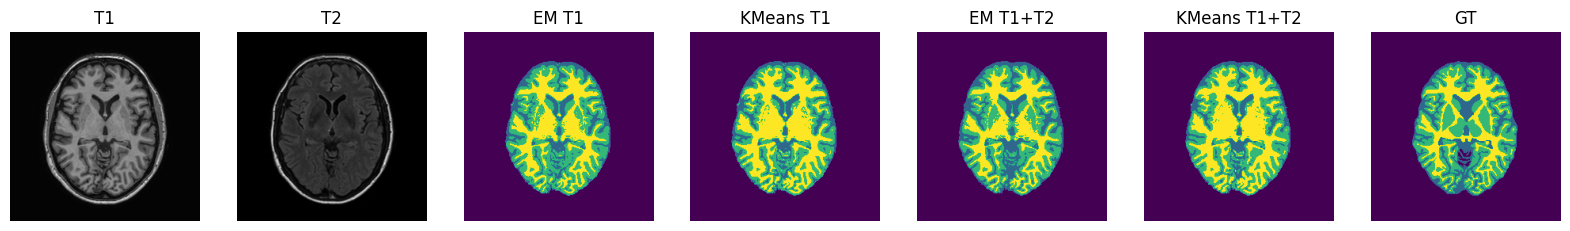

-------------------- Subject N°4 --------------------


 11%|█         | 11/100 [00:01<00:15,  5.78it/s]


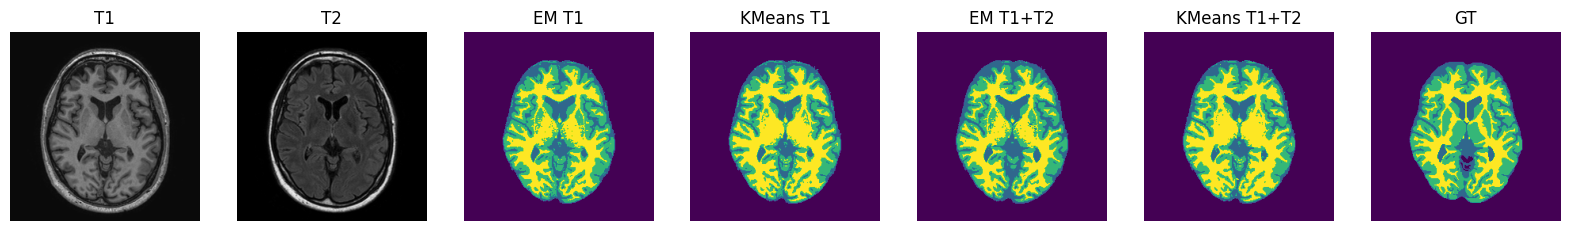

,CSF,GM,WM,modalities,subject,model,time
0,0.196461,0.381047,0.377363,t1,0,km,0.659459
1,0.205806,0.385865,0.374063,t1_t2,0,km,2.047297
2,0.196371,0.367561,0.378319,t1,0,em,2.346353
3,0.184180,0.359855,0.379540,t1_t2,0,em,10.069814
4,0.155767,0.432655,0.342871,t1,1,km,0.761232
5,0.156697,0.438058,0.341752,t1_t2,1,km,2.016522
6,0.155016,0.429171,0.343602,t1,1,em,1.656077
7,0.148619,0.396219,0.341259,t1_t2,1,em,14.477245
8,0.178173,0.358531,0.407490,t1,2,km,0.651036
9,0.183224,0.364294,0.404132,t1_t2,2,km,2.066953


In [3]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i} {"-"*20}')
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')

    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)

    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    t1_seg_res_em, t1_t2_seg_res_em, t_t1_em, t_t1_t2_em = brain_tissue_segmentation(t1_array, t2_array, bm, 'em')
    t1_seg_res_km, t1_t2_seg_res_km, t_t1_km, t_t1_t2_km = brain_tissue_segmentation(t1_array, t2_array, bm, 'km')

    t1_seg_res_em = utils.match_pred_w_gt(t1_seg_res_em, gt_array, t1_array)
    t1_t2_seg_res_em = utils.match_pred_w_gt(t1_t2_seg_res_em, gt_array, t1_array, t2_array)
    t1_seg_res_km = utils.match_pred_w_gt(t1_seg_res_km, gt_array, t1_array)
    t1_t2_seg_res_km = utils.match_pred_w_gt(t1_t2_seg_res_km, gt_array, t1_array, t2_array)

    dice_scores.append(dice_score(gt_array, t1_seg_res_km) + ['t1', i, 'km', t_t1_km])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_km) + ['t1_t2', i, 'km', t_t1_t2_km])
    dice_scores.append(dice_score(gt_array, t1_seg_res_em) + ['t1', i, 'em', t_t1_em])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em) + ['t1_t2', i, 'em', t_t1_t2_em])
    
    plots(t1_array, t2_array, t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt_array, slice_n = 20)
        
dice_scores = pd.DataFrame(data=dice_scores, columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'time'])
dice_scores.to_csv('dice_scores.csv')
dice_scores